In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Print the column names and data types
inspector = inspect(engine)
print(inspector.get_table_names())
print()

print('[measurement]')
columns1 = inspector.get_columns('measurement')
for column in columns1:
    print(column['name'], column['type'])

print()
print('[station]')
columns1 = inspector.get_columns('station')
for column in columns1:
    print(column['name'], column['type'])

['measurement', 'station']

[measurement]
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

[station]
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


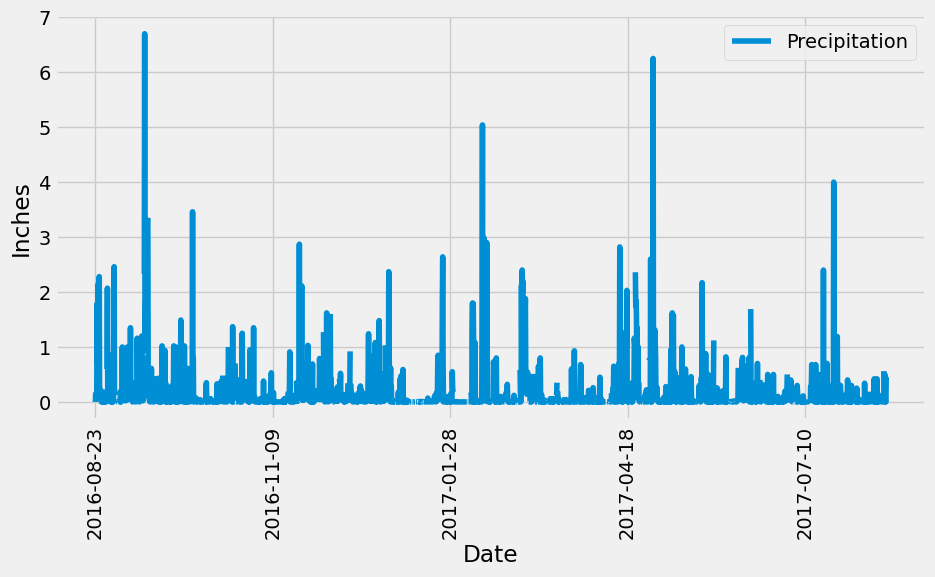

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
previous_year_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= previous_year_date).\
    filter(Measurement.date <= most_recent_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_year, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
sorted_df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(xlabel='Date', ylabel='Inches', rot=90, figsize=(10,5))

plt.savefig('last_year_prcp.png', bbox_inches='tight')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
station_count

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = station_count[0]
most_active = station_id[0]

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).scalar()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).scalar()

print(f"[({min_temp}, {max_temp}, {avg_temp})]")

[(54.0, 85.0, 71.66378066378067)]


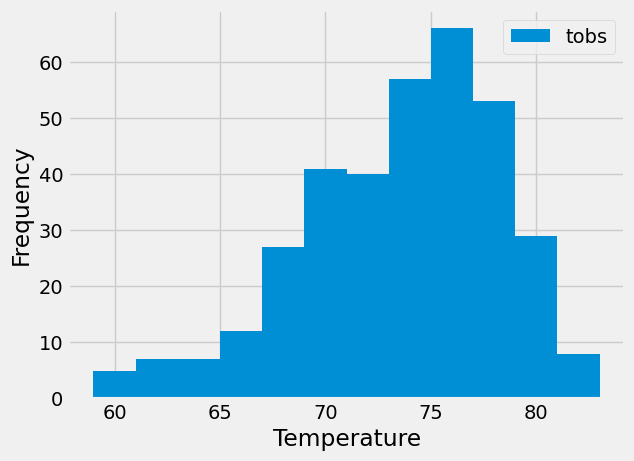

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active).\
            filter(Measurement.date >= previous_year_date).all()

results_df = pd.DataFrame(results, columns=['tobs'])

results_df.plot.hist(bins=12)
plt.xlabel('Temperature')

plt.savefig('action_station_temp_hist.png', bbox_inches='tight')
plt.show()

# Close Session

In [17]:
# Close Session
session.close()